In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import torch.nn as nn
from glob import glob
from os.path import expanduser, join, basename, dirname
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from itertools import product
from torch.utils.data import TensorDataset, DataLoader
from astra.torch.models import EfficientNetClassifier,EfficientNet_B0_Weights
from astra.torch.utils import train_fn

import torchvision.models as models
from astra.torch.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report

In [2]:
# Load the saved tensors
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/data.pt")

# Access the tensors
index = loaded_data['index']
images = loaded_data['images']
labels = loaded_data['labels']
images = images / 255
# mean normalize
images = (images - images.mean(dim=(0, 2, 3), keepdim=True)) / images.std(dim=(0, 2, 3), keepdim=True)
#print shape of tensors
print(images.shape)
print(labels.shape)
#print the labels
print(labels)
#count the number of unique labels
# count the number of 1s and 0s
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

subset_labels = labels[:17000]   
num_ones = np.count_nonzero(subset_labels == 1)
num_zeros = np.count_nonzero(subset_labels == 0)

print(f"Number of 1s(train ): {num_ones}")
print(f"Number of 0s(train): {num_zeros}")

torch.Size([25500, 3, 224, 224])
torch.Size([25500])
tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.uint8)
{0: 23803, 1: 1697}
Number of 1s(train ): 1085
Number of 0s(train): 15915


In [3]:
train_dataset = TensorDataset(images[:17000], labels[:17000])

test_dataset = TensorDataset(images[17000:], labels[17000:])

print(len(train_dataset))
print(len(test_dataset))
batch_size = 254
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

17000
8500
cuda


In [4]:
train_model = EfficientNetClassifier(
    models.efficientnet_b0,EfficientNet_B0_Weights, n_classes=2, activation=nn.ReLU(), dropout=0.1
).to(device)

iter_losses, epoch_losses = train_fn(
    train_model,
    nn.CrossEntropyLoss(),
    dataloader=train_loader,
    lr=3e-4,
    epochs=100,
    verbose=True,
    wandb_log=False,
)

/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loss: 0.00134156: 100%|██████████| 100/100 [36:48<00:00, 22.09s/it]


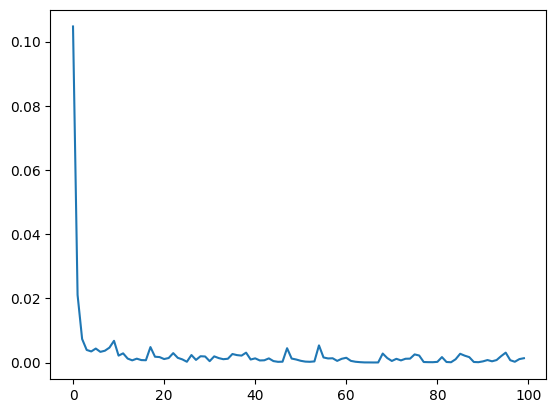

In [5]:
plt.plot(epoch_losses)

In [6]:
with torch.no_grad():
    pred_classes =train_model.predict_class(
        dataloader=test_loader, batch_size=batch_size, verbose=True
    ).to(device)

test_labels = labels[17000:].to(device)
print("Accuracy: ", accuracy_score(pred_classes,test_labels))
print("Precision: ", precision_score(pred_classes,test_labels))
print("Recall: ", recall_score(pred_classes,test_labels))
print("F1: ", f1_score(pred_classes,test_labels))
print("classification report: ", classification_report(pred_classes,test_labels))

100%|██████████| 34/34 [00:05<00:00,  6.02it/s]


Accuracy:  tensor(0.9813, device='cuda:0')
Precision:  tensor(0.8731, device='cuda:0')
Recall:  tensor(0.8660, device='cuda:0')
F1:  tensor(0.8696, device='cuda:0')
classification report:  {'accuracy': tensor(0.9813, device='cuda:0'), 'precision': tensor(0.8731, device='cuda:0'), 'recall': tensor(0.8660, device='cuda:0'), 'f1': tensor(0.8696, device='cuda:0')}


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
print("Classification Report:\n", classification_report(test_labels.cpu().numpy(), pred_classes.cpu().numpy()))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7888
           1       0.87      0.87      0.87       612

    accuracy                           0.98      8500
   macro avg       0.93      0.93      0.93      8500
weighted avg       0.98      0.98      0.98      8500

